In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


# CSCI 631 Project 1 Object Detection

<font color="red">Due date: March 23 2021, 11:59</font>

Object detection is one of the fundamental problems in computer vision. In this project, we will write a code for single object detection. You may need to use PyTorch, NumPy, and Pandas to finish this project. Please make sure you understand the lecture material (CNN on MNIST) before you start this project.

Before Running the codes:
please make sure that you uploaded the datasets to the left directory
Not in the google drive because I found it extremely slow when reading the data
Upload all four csv files individually: 
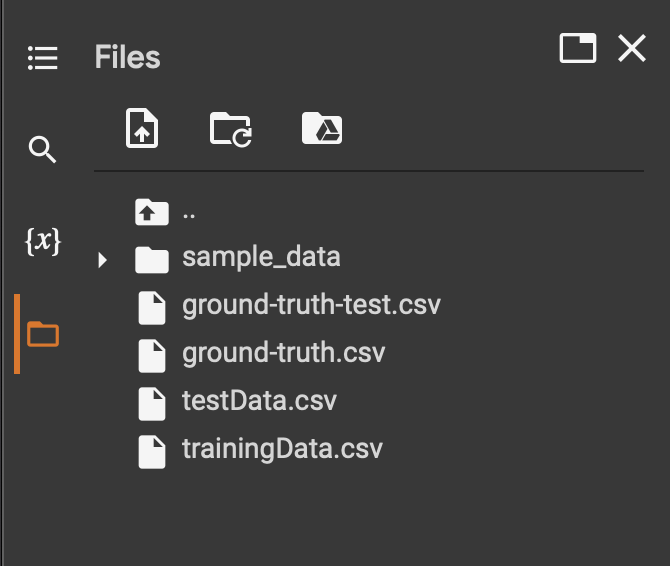

## Question 1 Write a data loader.

1. write a fucntion which use Pandas.read_csv() to read the training data and the ground truth of training (dataset directory)

2. Save the data and the ground truth in self.featurestrain and self.groundtruthtrain (tensor format).

3. Save the length of data in self.len.



### training_dataset.py/training_dataset module


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
path_of_dataset_folder="/content/"
# e.g. the path of "ground-truth-test" is path_of_dataset_folder+"/ground-truth-test.csv"

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


class training_dataset(Dataset):
    def __init__(self):
        '''
        read the training data and ground truth.
        implement your code here
        '''
        #these 2 lines, we use pandas to read the cvs files for the training datas and the groud truth datas
        training = pd.read_csv(path_of_dataset_folder + "trainingData.csv", header=None)
        ground = pd.read_csv(path_of_dataset_folder + "ground-truth.csv", header=None)
        self.featurestrain = torch.tensor(training.to_numpy(), dtype=torch.float)
        self.groundTruthtrain = torch.tensor(ground.to_numpy(), dtype=torch.float)

        self.len = len(training)



    def __getitem__(self, item):
        return self.featurestrain[item], self.groundTruthtrain[item]

    def __len__(self):
        return self.len

## Question 2 Implement an overlap score function.

1. Use this overlapScore to find out left, right, top, bottom.

2. Briefly describe how you implemented the overlap score function in your pdf report.

### function.py/function module

### I used the minimum of the topleft corner for top section
### and I use minimum of the bottom right corner for the bot section, and the left right section belongs to the maximum beyond those

In [ ]:


'''
Function to calculate the overlap ratio given the ground-truth and predicted bounding boxes.
'''

def overlapScore(rects1, rects2):

    avgScore = 0
    scores = []

    for i, _ in enumerate(rects1):

        rect1 = rects1[i]
        rect2 = rects2[i]

        # find out left, right, top, bottom
        # implement your code here:
        top = np.minimum(rect1[1] + rect1[3], rect2[1]+rect2[3])

        bottom = np.maximum(rect1[1], rect2[1])

        right = np.minimum(rect1[0] + rect1[2], rect2[0] + rect2[2])

        left = np.maximum(rect1[0], rect2[0])

        # area of intersection
        i = np.max((0, right-left))*np.max((0,top-bottom))

        # combined area of two rectangles
        u = rect1[2]*rect1[3] + rect2[2]*rect2[3] - i

        # return the overlap ratio
        # value is always between 0 and 1
        score = np.clip(i/u, 0, 1)
        avgScore += score
        scores.append(score)

    return avgScore, scores

## Question 3 CNN model

1. In cnn_model.py file, complete the **forward** function according to the instructions. The CNN model contains three convolutional layers, one fully connected layer and one output layer with 4 nodes. A kernel of size 5 with stride 1 is applied in each convolution layer. The first two convolutional layers are followed by a max-pooling layer with kernel size 2 and stride 2. We need to set up a dropout rate (0.5) on the fully connected layer. All inner layers are activated by ReLU function.

2. Briefly describe how you implement CNN model in your pdf report

### cnn_model.py/cnn_model module

### The method I used here is that I use relu first for value to chekc whether the value is positive or negative, if its negative, it will become a zero value, else its just itseld. then passing into 2d pooling because the rectangle is just 2d. that is all we needed. so in the maxpool2d if there nothing wrong with the value, the spatial dimensionl will be reduced and further more extracted with more accurate value. Then using dropout function applies the bernoulie distribution for randomness in the trainning

In [ ]:
#import torch.nn as nn
#import torch.nn.functional as f
class cnn_model(nn.Module):
    '''
    The CNN model contains three convolutional layers, one fully connected layer and one output layer with 4 nodes.
A kernel of size 5 with stride 1 is applied in each convolution layer. The first two convolutional layers are followed by a max-pooling layer with kernel size 2 and stride 2.
We need to set up a dropout rate (0.5) on the fully connected layer.
All inner layers are activated by ReLU function.
    '''
    def __init__(self):

        super(cnn_model, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=32,
            kernel_size=5,
            stride=1,
            padding=0
        )

        self.conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=5,
            stride=1,
            padding=0
        )

        self.conv3 = nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=5,
            stride=1,
            padding=0
        )


        self.fc1 = nn.Linear(
            in_features=18*18*128,
            out_features=2046
        )

        self.fc2 = nn.Linear(
            in_features=2046,
            out_features=4
        )

    def forward(self, val):


        # implement your code here:
        val = f.relu(self.conv1(val))
        val = f.max_pool2d(val, kernel_size = 2, stride=2)
        
        val = f.relu(self.conv2(val))
        val = f.max_pool2d(val, kernel_size = 2, stride=2)

        val = f.relu(self.conv3(val))
        val = val.view(-1, 18*18*128)
        val = f.dropout(f.relu(self.fc1(val)), p=0.5)
        val = self.fc2(val)

        return val

## Question 4 Train your model
In train_cnn.py, follow the instructions and complete the training code.
1. Set up hyperparameters.
2. Load dataset
3. Complete the train_model function according to instructions in train_cnn.py.
4. Briefly describe how you implement the train_model function in your pdf report


### I used the MSE loss function to measure the difference of truth value vs the predicted value. Then within the torch, there are SGD optimizer tools as the file directed us to do also with scheduler

### Here we have to set the GPU for function, in GOOGLE COLAB, click Edit and Notebook Setting, then choose GPU for better performance.

### Within the forloop, I just set up the loss function array and train with the training datasets. here we have to use detach.numpy() to get the tensor work with other function. Set up the function to run with cpu and Cuda

## Using the dataloader as directed by the TA, reading datas and set for trainning

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader
# import numpy as np
# import pandas as pd
# from function import overlapScore

#no need to import from different file if running in google colab
#from cnn_model import *
#from training_dataset import *
'''
In this part we will train the model.
'''
def train_model(net, dataloader, batchSize, lr_rate, momentum, Epoch_num):
    '''
    training process of this model
    :param net: model
    :param dataloader: dataloader
    :param batchSize: batch size
    :param lr_rate: learning rate
    :param momentum: momentum
    :param Epoch_num: epoch number
    :return:
    '''
    '''
    setup loss function(mean squared error loss)
    optimization (stochastic gradient descent)
    scheduler(hint: optim.lr_scheduler.StepLR(), step_size=30, gamma=0.1)
    '''
    # implement your code here:
    criterion = nn.MSELoss()
    optimization = torch.optim.SGD(net.parameters(), lr=lr_rate, momentum=momentum)
    scheduler = optim.lr_scheduler.StepLR(optimization, step_size=30, gamma=0.1)

    #run setting
    device = torch.device('cpu')
    if torch.cuda.is_available():
      device = torch.device('cuda')
    net.to(device)

    '''
    loop for training
    '''
    # implement your code here:
    for epoch in range(Epoch_num):

        scheduler.step()

        losses = []
        avgScores = 0

        for i, data in enumerate(dataloader):
            # clear the gradients for all optimized variables
            optimization.zero_grad()

            # forward pass: compute predicted outputs by passing inputs to the model
            inputs, labels = data
            inputs, labels = (inputs.view(batchSize, 1, 100, 100).to(device)), (labels.view(batchSize, 4).to(device))
            outputs = net(inputs)
            # calculate the loss
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimization.step()
            # calculate the score using overlapScore function
            pbox = outputs.cpu().detach().numpy()
            gbox = labels.cpu().detach().numpy()
            avgScore, scores = overlapScore(pbox, gbox)
            avgScores += avgScores

        '''
        print out epoch, loss and average score in following format
        epoch     1, loss: 426.835693, Average Score = 0.046756
        '''


    print('Finish Training')


if __name__ == '__main__':
    # hyper parameters
    # implement your code here
    learning_rate = 0.000005
    momentum = 0.9
    batch = 4
    no_of_workers = torch.get_num_threads()
    shuffle = True
    epoch = 30

    # load dataset
    # implement your code here
    data = training_dataset()

    # setup dataloader
    # implement your code here
    dataLoader = DataLoader(dataset=data, batch_size=batch, shuffle=shuffle, num_workers=no_of_workers)


    model = cnn_model()
    model.train()

    train_model(model, dataLoader, batch,learning_rate, momentum, epoch)
    # save model
    torch.save(model.state_dict(), 'model.pth')




/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Finish Training


## Question 5 Test your model:

Complete the testing in test_model.py

1. Load testing data in Dataset/testData.csv and Dataset/ground-truth-test.csv.

2. Load your model and test your model. (Print the Intersection over Union score and provide one picture with the bounding box in your pdf report/jpynb text cell)


### test_model.py


### In the testing part, I used the matplot's ax show to display the rectangle and also with the rectangle method of the matplot provided. then I can add the predicted layout of thhe rectangle and also the truth lay out of the rectangle so that we can see the difference. The image will be display in the output and also will store individually as files in the left content. The orange part shows the original rectangle and the red edge with hollow will display the predicted part. Due to the technical issue, I am not able to make a Result directory on the google colab. After this function finished running, the picture will be show in the below and will save the image in the corresponding name on the left "Files".

<Figure size 1080x720 with 0 Axes>

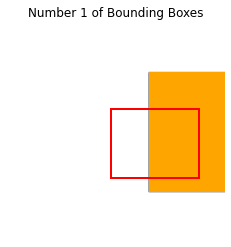

<Figure size 1080x720 with 0 Axes>

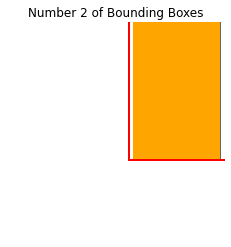

<Figure size 1080x720 with 0 Axes>

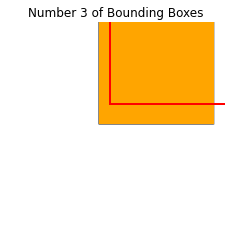

<Figure size 1080x720 with 0 Axes>

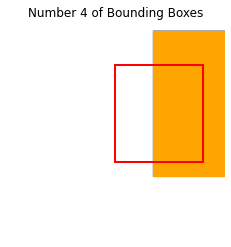

<Figure size 1080x720 with 0 Axes>

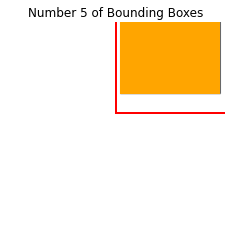

<Figure size 1080x720 with 0 Axes>

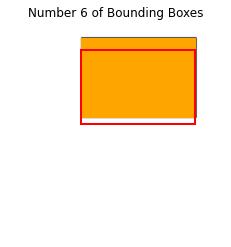

<Figure size 1080x720 with 0 Axes>

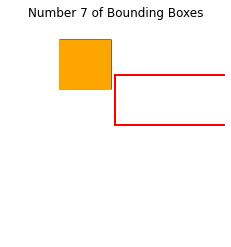

<Figure size 1080x720 with 0 Axes>

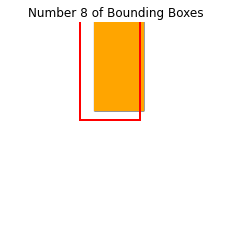

<Figure size 1080x720 with 0 Axes>

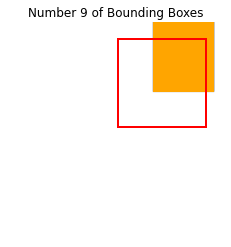

<Figure size 1080x720 with 0 Axes>

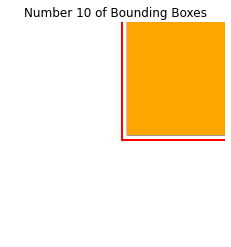

<Figure size 1080x720 with 0 Axes>

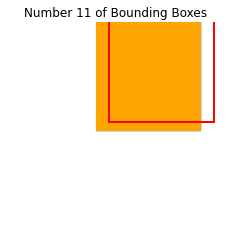

<Figure size 1080x720 with 0 Axes>

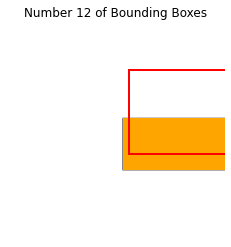

<Figure size 1080x720 with 0 Axes>

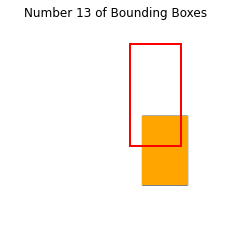

<Figure size 1080x720 with 0 Axes>

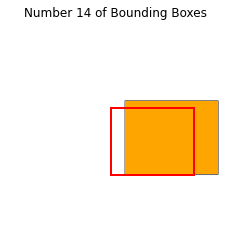

<Figure size 1080x720 with 0 Axes>

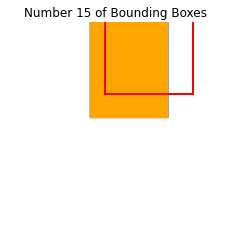

<Figure size 1080x720 with 0 Axes>

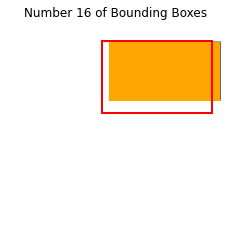

<Figure size 1080x720 with 0 Axes>

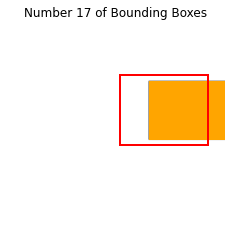

<Figure size 1080x720 with 0 Axes>

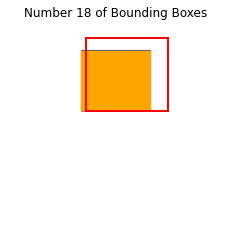

<Figure size 1080x720 with 0 Axes>

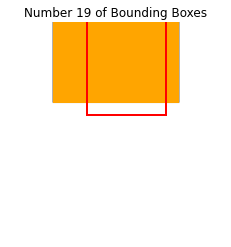

<Figure size 1080x720 with 0 Axes>

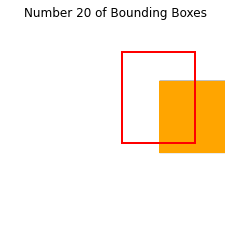

<Figure size 1080x720 with 0 Axes>

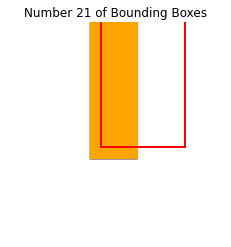

<Figure size 1080x720 with 0 Axes>

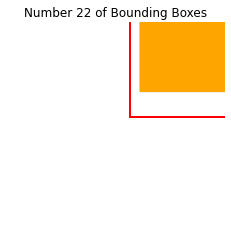

<Figure size 1080x720 with 0 Axes>

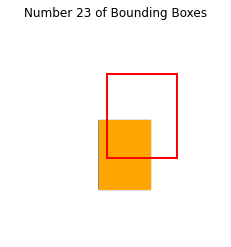

<Figure size 1080x720 with 0 Axes>

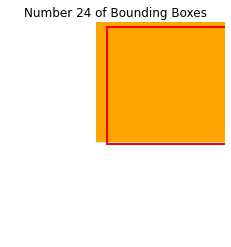

<Figure size 1080x720 with 0 Axes>

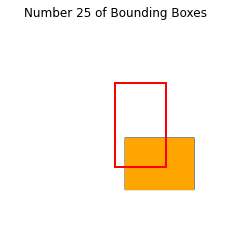

<Figure size 1080x720 with 0 Axes>

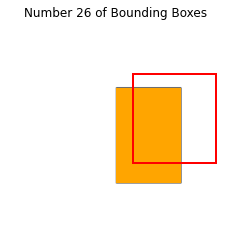

<Figure size 1080x720 with 0 Axes>

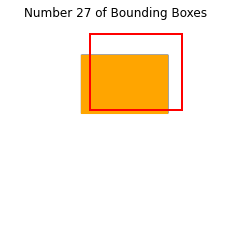

<Figure size 1080x720 with 0 Axes>

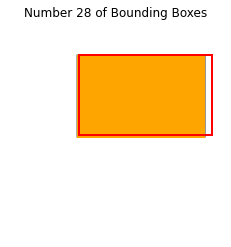

<Figure size 1080x720 with 0 Axes>

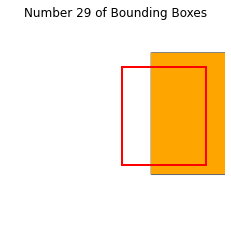

<Figure size 1080x720 with 0 Axes>

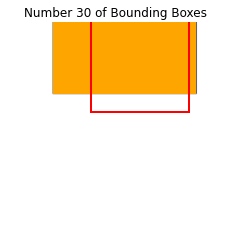

<Figure size 1080x720 with 0 Axes>

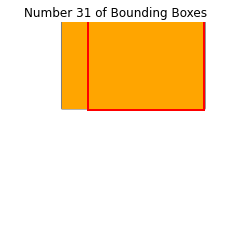

<Figure size 1080x720 with 0 Axes>

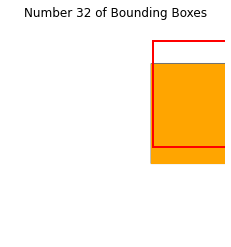

<Figure size 1080x720 with 0 Axes>

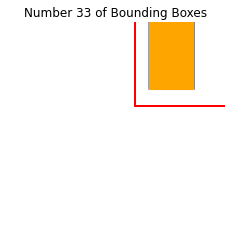

<Figure size 1080x720 with 0 Axes>

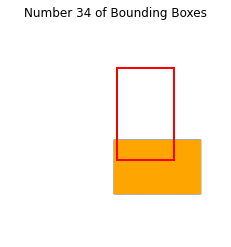

<Figure size 1080x720 with 0 Axes>

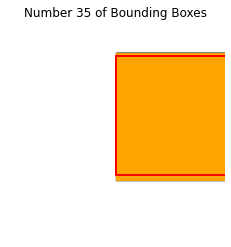

<Figure size 1080x720 with 0 Axes>

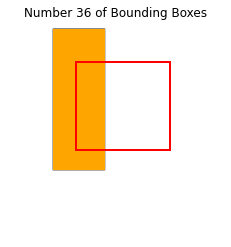

<Figure size 1080x720 with 0 Axes>

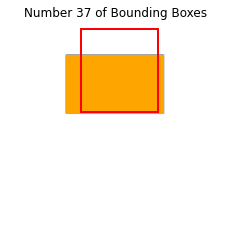

<Figure size 1080x720 with 0 Axes>

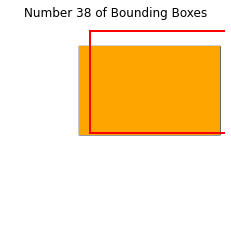

<Figure size 1080x720 with 0 Axes>

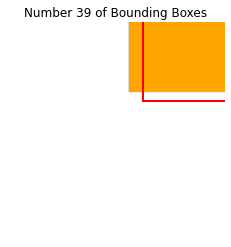

<Figure size 1080x720 with 0 Axes>

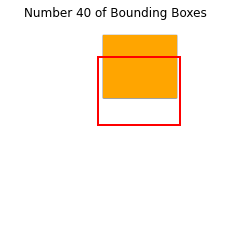

<Figure size 1080x720 with 0 Axes>

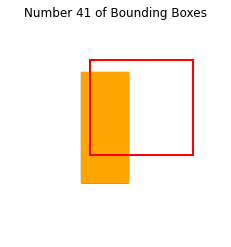

<Figure size 1080x720 with 0 Axes>

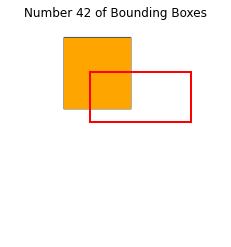

<Figure size 1080x720 with 0 Axes>

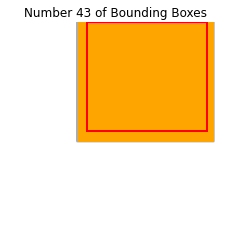

<Figure size 1080x720 with 0 Axes>

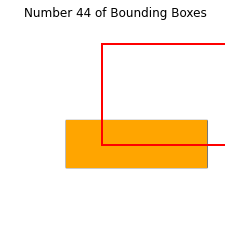

<Figure size 1080x720 with 0 Axes>

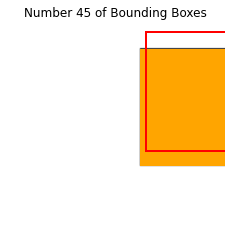

<Figure size 1080x720 with 0 Axes>

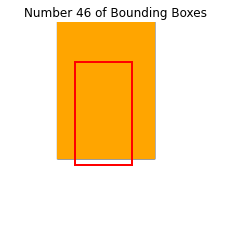

<Figure size 1080x720 with 0 Axes>

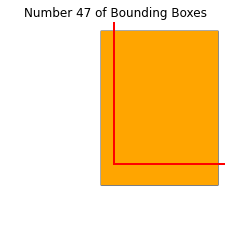

<Figure size 1080x720 with 0 Axes>

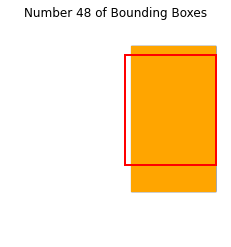

<Figure size 1080x720 with 0 Axes>

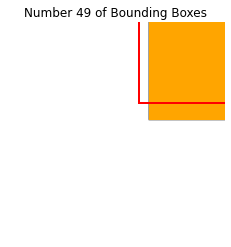

<Figure size 1080x720 with 0 Axes>

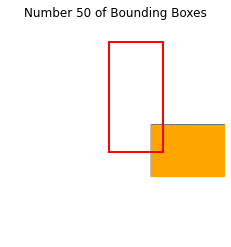

<Figure size 1080x720 with 0 Axes>

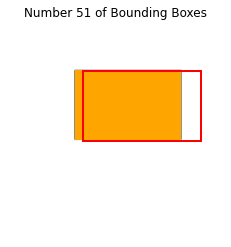

<Figure size 1080x720 with 0 Axes>

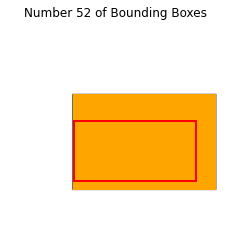

<Figure size 1080x720 with 0 Axes>

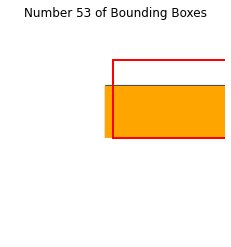

<Figure size 1080x720 with 0 Axes>

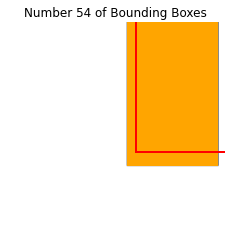

<Figure size 1080x720 with 0 Axes>

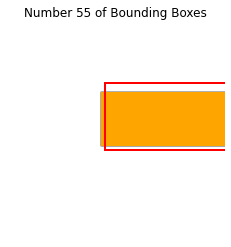

<Figure size 1080x720 with 0 Axes>

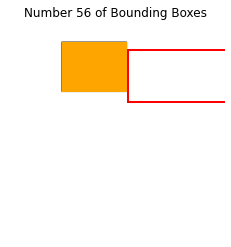

<Figure size 1080x720 with 0 Axes>

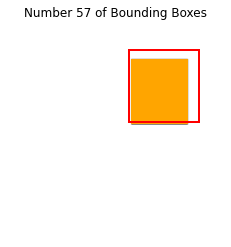

<Figure size 1080x720 with 0 Axes>

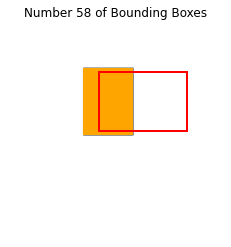

<Figure size 1080x720 with 0 Axes>

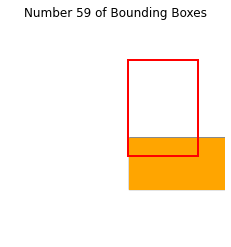

<Figure size 1080x720 with 0 Axes>

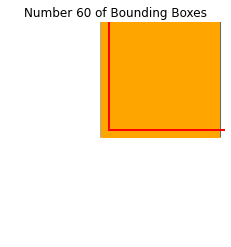

<Figure size 1080x720 with 0 Axes>

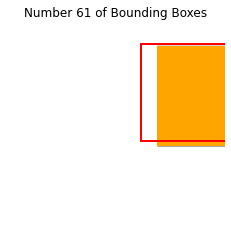

<Figure size 1080x720 with 0 Axes>

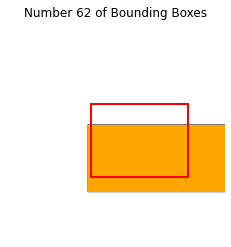

<Figure size 1080x720 with 0 Axes>

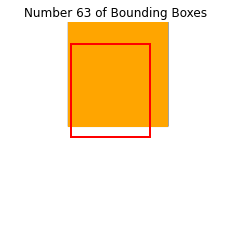

<Figure size 1080x720 with 0 Axes>

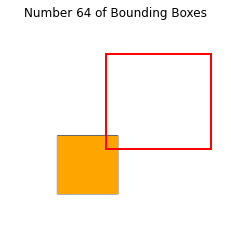

<Figure size 1080x720 with 0 Axes>

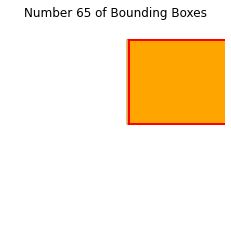

<Figure size 1080x720 with 0 Axes>

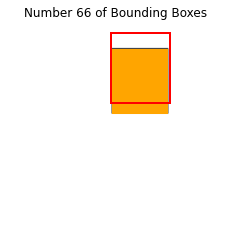

<Figure size 1080x720 with 0 Axes>

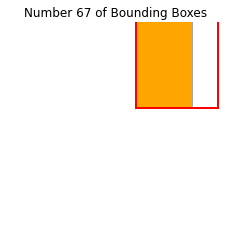

<Figure size 1080x720 with 0 Axes>

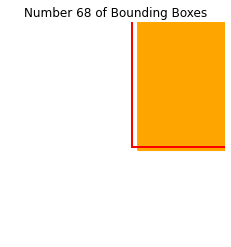

<Figure size 1080x720 with 0 Axes>

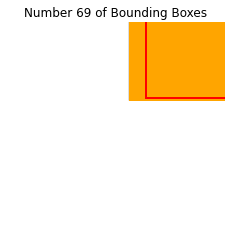

<Figure size 1080x720 with 0 Axes>

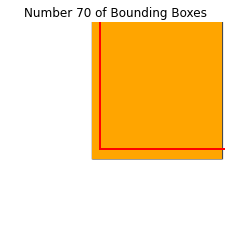

<Figure size 1080x720 with 0 Axes>

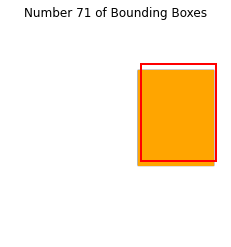

<Figure size 1080x720 with 0 Axes>

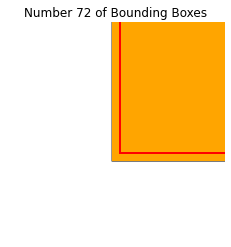

<Figure size 1080x720 with 0 Axes>

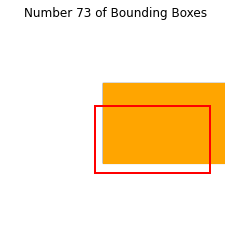

<Figure size 1080x720 with 0 Axes>

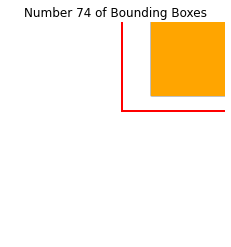

<Figure size 1080x720 with 0 Axes>

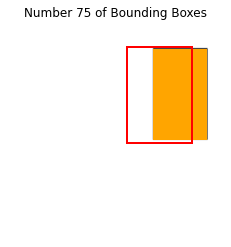

<Figure size 1080x720 with 0 Axes>

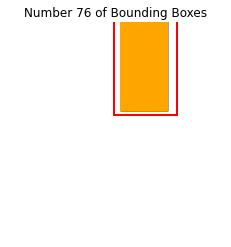

<Figure size 1080x720 with 0 Axes>

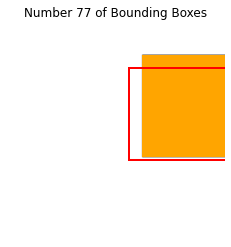

<Figure size 1080x720 with 0 Axes>

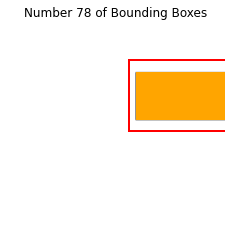

<Figure size 1080x720 with 0 Axes>

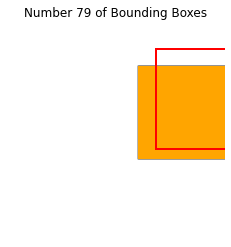

<Figure size 1080x720 with 0 Axes>

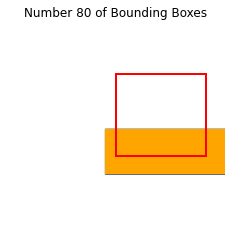

<Figure size 1080x720 with 0 Axes>

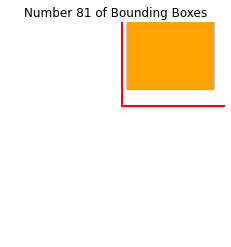

<Figure size 1080x720 with 0 Axes>

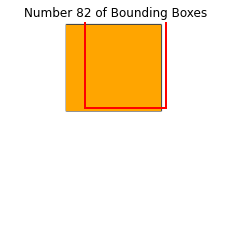

<Figure size 1080x720 with 0 Axes>

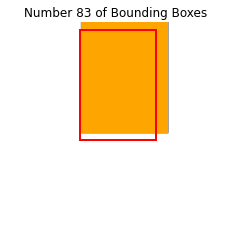

<Figure size 1080x720 with 0 Axes>

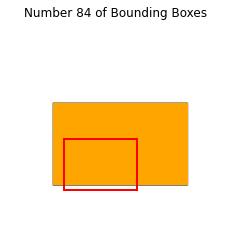

<Figure size 1080x720 with 0 Axes>

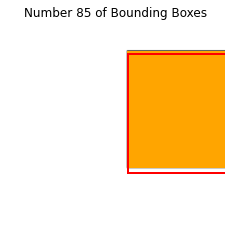

<Figure size 1080x720 with 0 Axes>

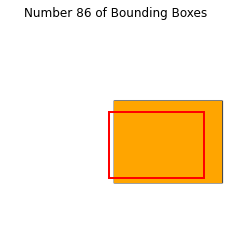

<Figure size 1080x720 with 0 Axes>

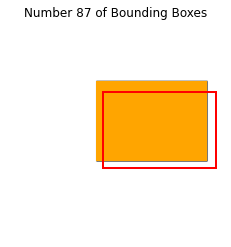

<Figure size 1080x720 with 0 Axes>

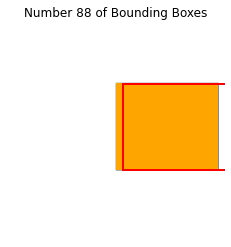

<Figure size 1080x720 with 0 Axes>

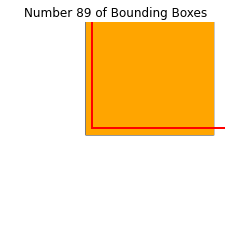

<Figure size 1080x720 with 0 Axes>

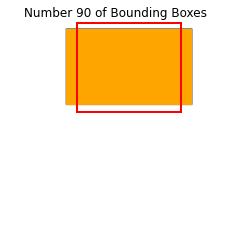

<Figure size 1080x720 with 0 Axes>

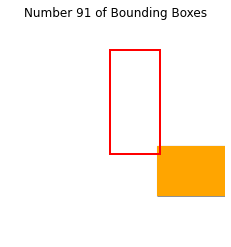

<Figure size 1080x720 with 0 Axes>

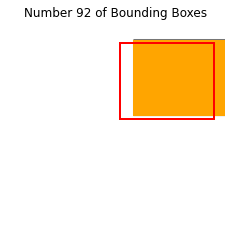

<Figure size 1080x720 with 0 Axes>

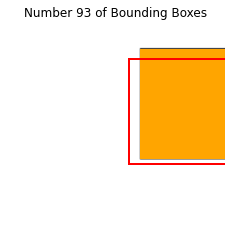

<Figure size 1080x720 with 0 Axes>

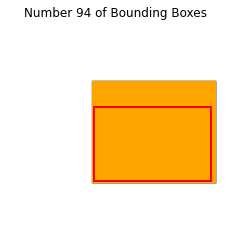

<Figure size 1080x720 with 0 Axes>

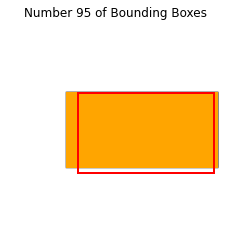

<Figure size 1080x720 with 0 Axes>

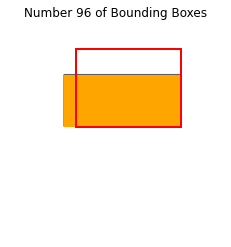

<Figure size 1080x720 with 0 Axes>

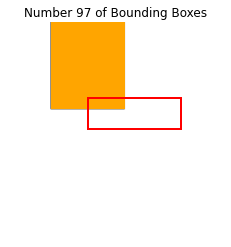

<Figure size 1080x720 with 0 Axes>

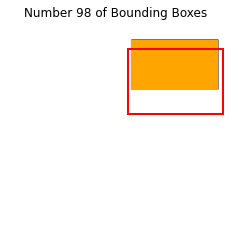

<Figure size 1080x720 with 0 Axes>

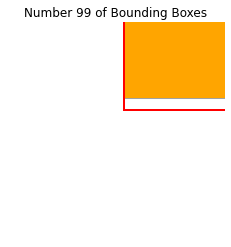

<Figure size 1080x720 with 0 Axes>

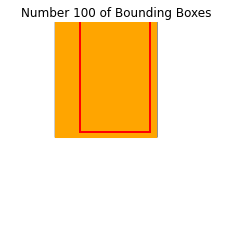

<Figure size 1080x720 with 0 Axes>

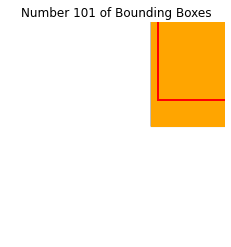

<Figure size 1080x720 with 0 Axes>

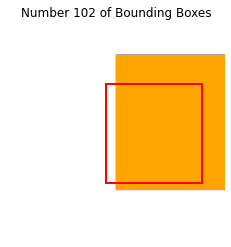

<Figure size 1080x720 with 0 Axes>

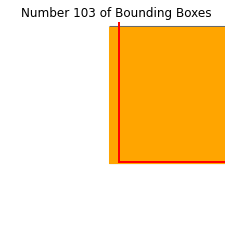

<Figure size 1080x720 with 0 Axes>

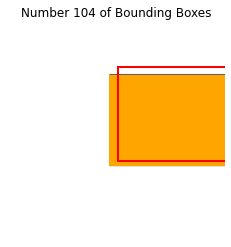

<Figure size 1080x720 with 0 Axes>

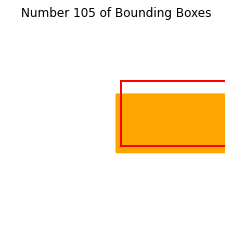

<Figure size 1080x720 with 0 Axes>

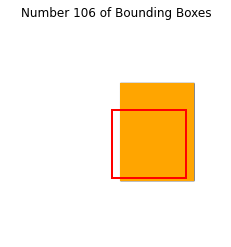

<Figure size 1080x720 with 0 Axes>

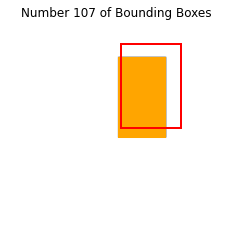

<Figure size 1080x720 with 0 Axes>

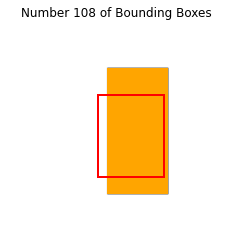

<Figure size 1080x720 with 0 Axes>

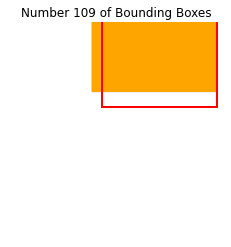

<Figure size 1080x720 with 0 Axes>

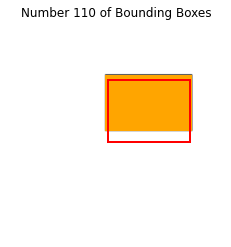

<Figure size 1080x720 with 0 Axes>

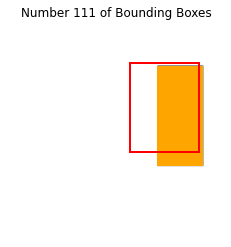

<Figure size 1080x720 with 0 Axes>

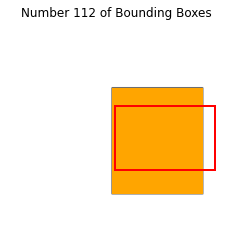

<Figure size 1080x720 with 0 Axes>

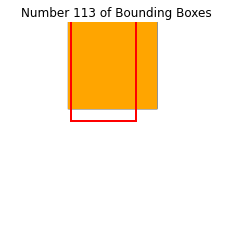

<Figure size 1080x720 with 0 Axes>

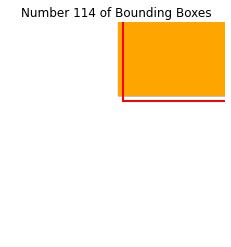

<Figure size 1080x720 with 0 Axes>

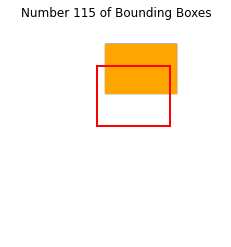

<Figure size 1080x720 with 0 Axes>

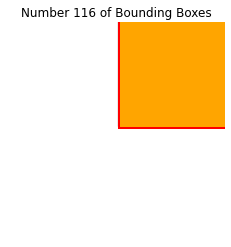

<Figure size 1080x720 with 0 Axes>

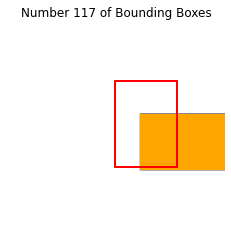

<Figure size 1080x720 with 0 Axes>

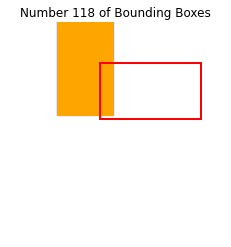

<Figure size 1080x720 with 0 Axes>

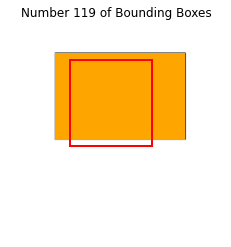

<Figure size 1080x720 with 0 Axes>

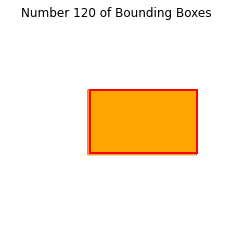

<Figure size 1080x720 with 0 Axes>

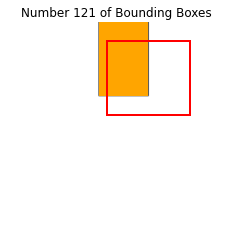

<Figure size 1080x720 with 0 Axes>

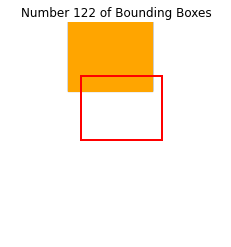

<Figure size 1080x720 with 0 Axes>

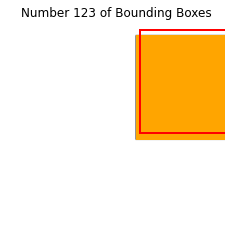

<Figure size 1080x720 with 0 Axes>

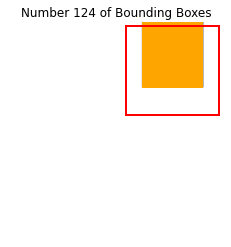

<Figure size 1080x720 with 0 Axes>

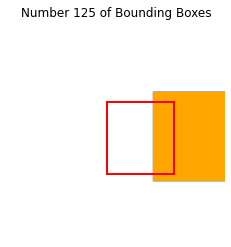

<Figure size 1080x720 with 0 Axes>

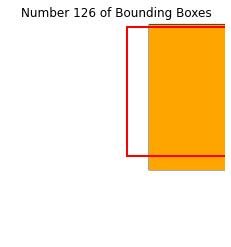

<Figure size 1080x720 with 0 Axes>

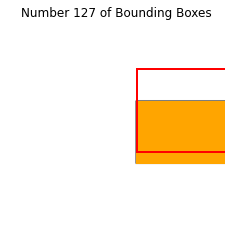

<Figure size 1080x720 with 0 Axes>

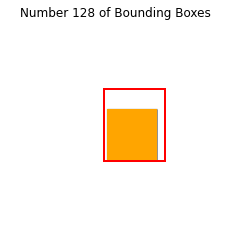

<Figure size 1080x720 with 0 Axes>

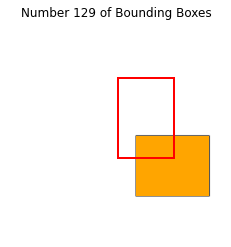

<Figure size 1080x720 with 0 Axes>

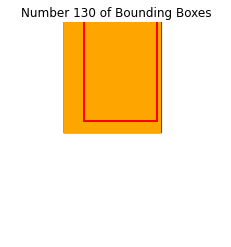

<Figure size 1080x720 with 0 Axes>

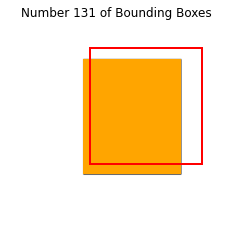

<Figure size 1080x720 with 0 Axes>

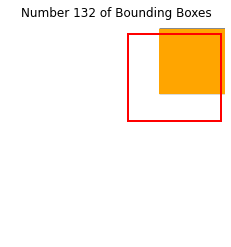

<Figure size 1080x720 with 0 Axes>

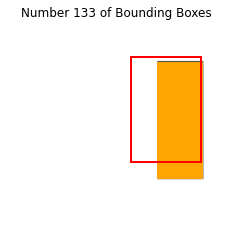

<Figure size 1080x720 with 0 Axes>

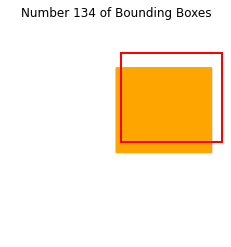

<Figure size 1080x720 with 0 Axes>

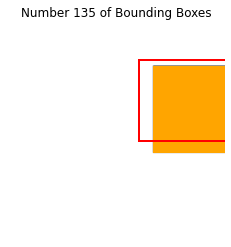

<Figure size 1080x720 with 0 Axes>

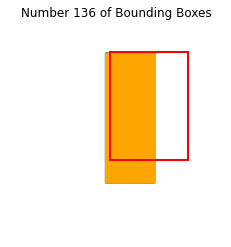

<Figure size 1080x720 with 0 Axes>

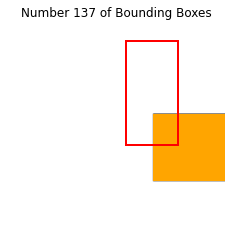

<Figure size 1080x720 with 0 Axes>

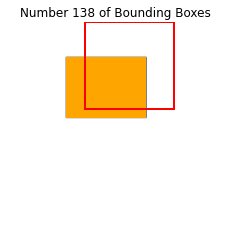

<Figure size 1080x720 with 0 Axes>

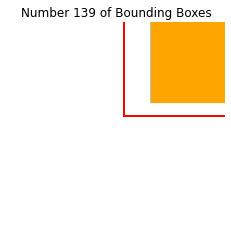

<Figure size 1080x720 with 0 Axes>

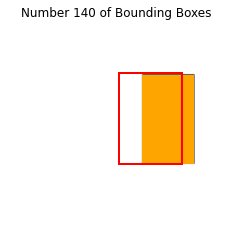

<Figure size 1080x720 with 0 Axes>

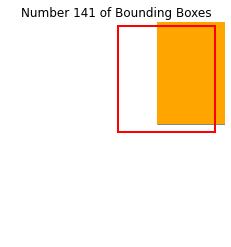

<Figure size 1080x720 with 0 Axes>

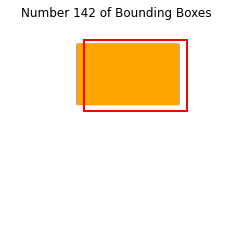

<Figure size 1080x720 with 0 Axes>

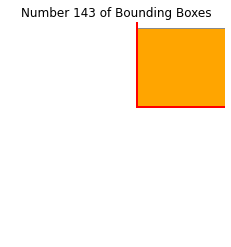

<Figure size 1080x720 with 0 Axes>

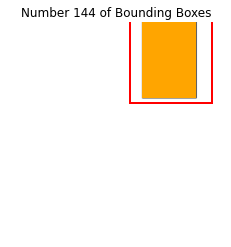

<Figure size 1080x720 with 0 Axes>

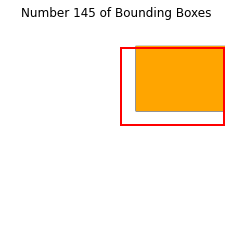

<Figure size 1080x720 with 0 Axes>

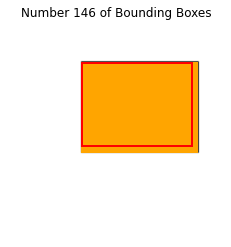

<Figure size 1080x720 with 0 Axes>

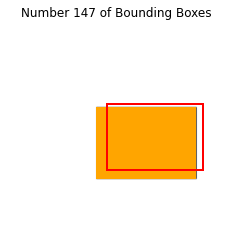

<Figure size 1080x720 with 0 Axes>

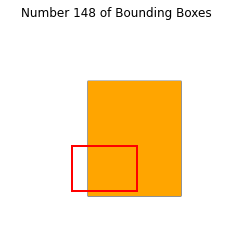

<Figure size 1080x720 with 0 Axes>

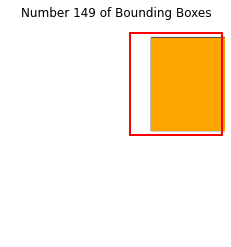

<Figure size 1080x720 with 0 Axes>

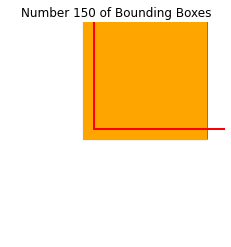

<Figure size 1080x720 with 0 Axes>

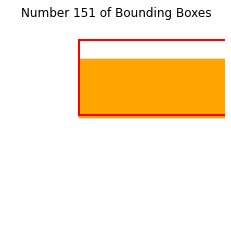

<Figure size 1080x720 with 0 Axes>

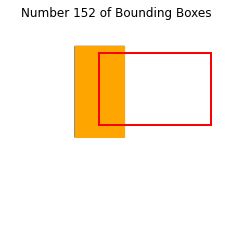

<Figure size 1080x720 with 0 Axes>

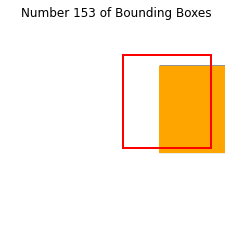

<Figure size 1080x720 with 0 Axes>

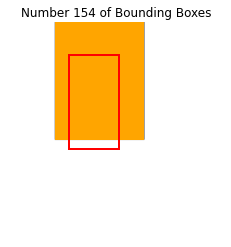

<Figure size 1080x720 with 0 Axes>

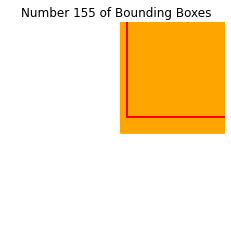

<Figure size 1080x720 with 0 Axes>

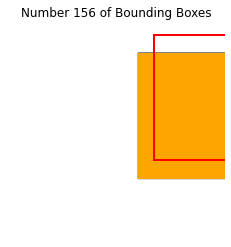

<Figure size 1080x720 with 0 Axes>

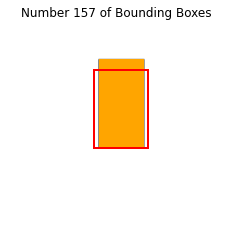

<Figure size 1080x720 with 0 Axes>

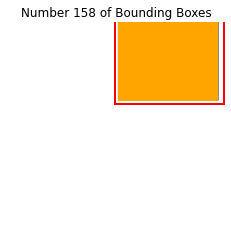

<Figure size 1080x720 with 0 Axes>

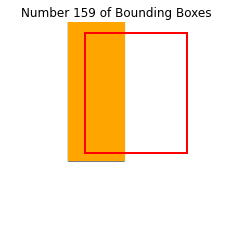

<Figure size 1080x720 with 0 Axes>

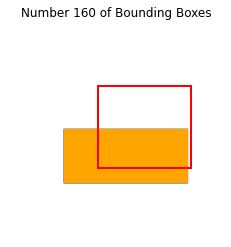

<Figure size 1080x720 with 0 Axes>

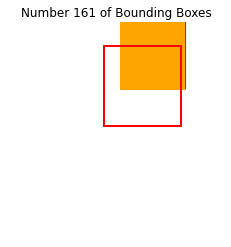

<Figure size 1080x720 with 0 Axes>

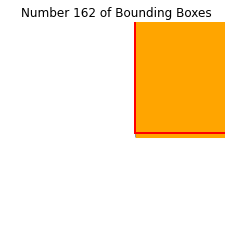

<Figure size 1080x720 with 0 Axes>

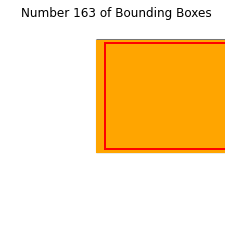

<Figure size 1080x720 with 0 Axes>

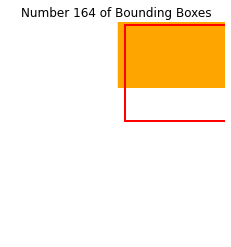

<Figure size 1080x720 with 0 Axes>

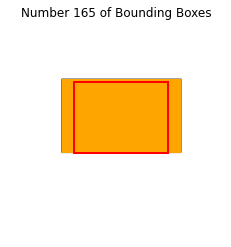

<Figure size 1080x720 with 0 Axes>

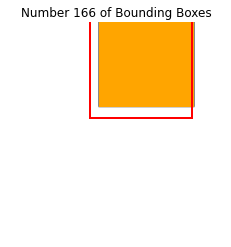

<Figure size 1080x720 with 0 Axes>

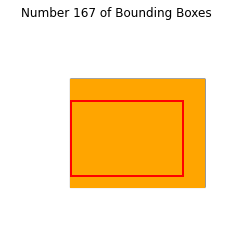

<Figure size 1080x720 with 0 Axes>

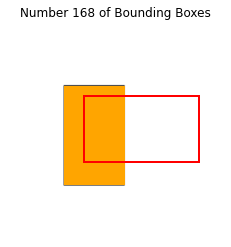

<Figure size 1080x720 with 0 Axes>

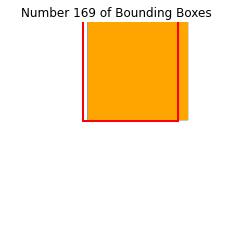

<Figure size 1080x720 with 0 Axes>

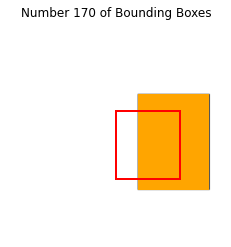

<Figure size 1080x720 with 0 Axes>

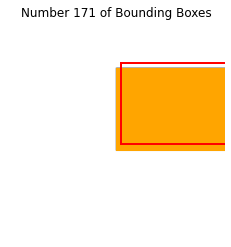

<Figure size 1080x720 with 0 Axes>

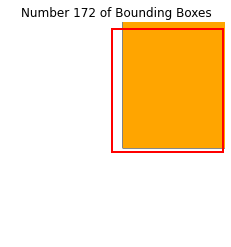

<Figure size 1080x720 with 0 Axes>

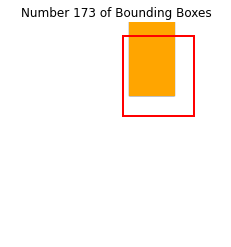

<Figure size 1080x720 with 0 Axes>

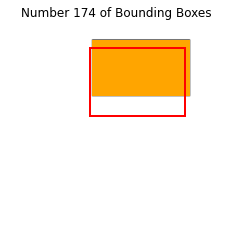

<Figure size 1080x720 with 0 Axes>

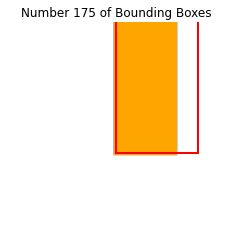

<Figure size 1080x720 with 0 Axes>

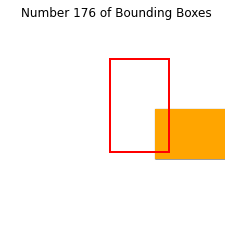

<Figure size 1080x720 with 0 Axes>

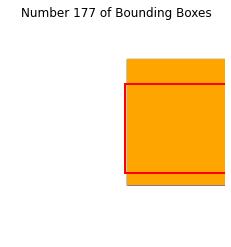

<Figure size 1080x720 with 0 Axes>

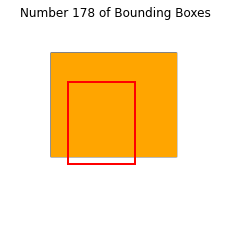

<Figure size 1080x720 with 0 Axes>

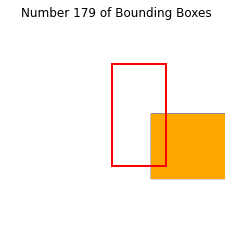

<Figure size 1080x720 with 0 Axes>

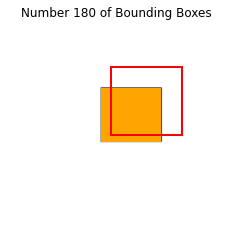

<Figure size 1080x720 with 0 Axes>

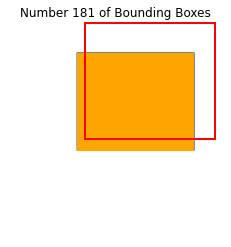

<Figure size 1080x720 with 0 Axes>

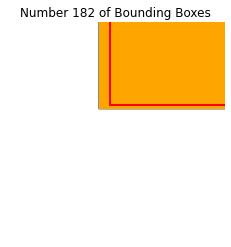

<Figure size 1080x720 with 0 Axes>

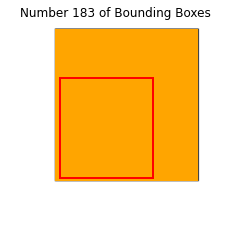

<Figure size 1080x720 with 0 Axes>

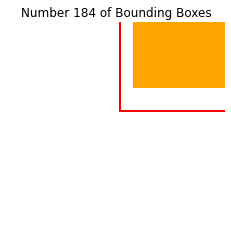

<Figure size 1080x720 with 0 Axes>

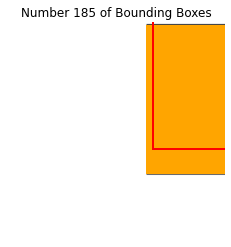

<Figure size 1080x720 with 0 Axes>

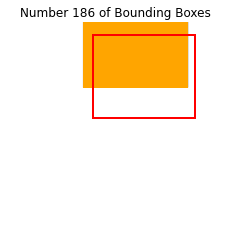

<Figure size 1080x720 with 0 Axes>

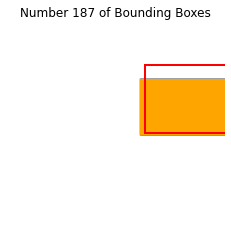

<Figure size 1080x720 with 0 Axes>

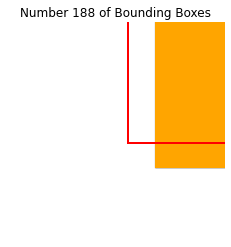

<Figure size 1080x720 with 0 Axes>

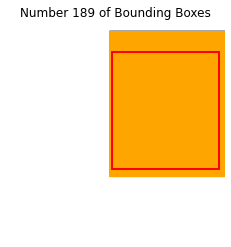

<Figure size 1080x720 with 0 Axes>

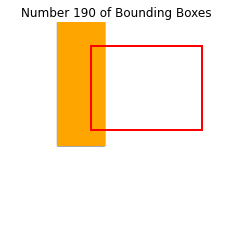

<Figure size 1080x720 with 0 Axes>

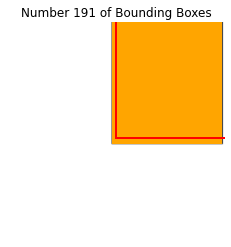

<Figure size 1080x720 with 0 Axes>

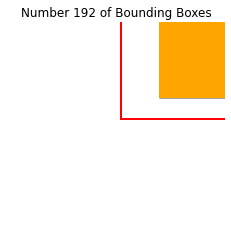

<Figure size 1080x720 with 0 Axes>

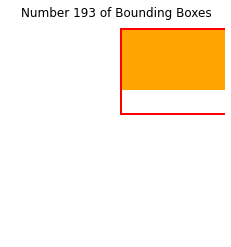

<Figure size 1080x720 with 0 Axes>

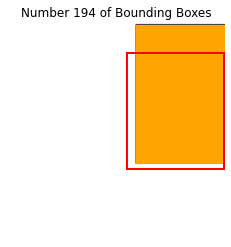

<Figure size 1080x720 with 0 Axes>

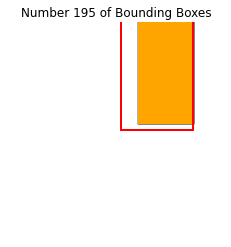

<Figure size 1080x720 with 0 Axes>

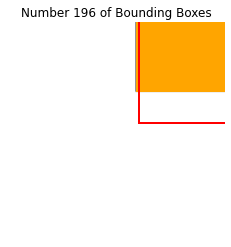

<Figure size 1080x720 with 0 Axes>

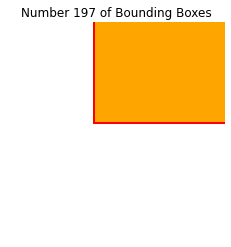

<Figure size 1080x720 with 0 Axes>

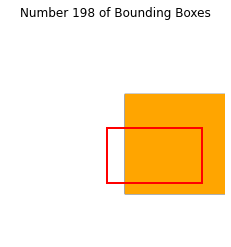

<Figure size 1080x720 with 0 Axes>

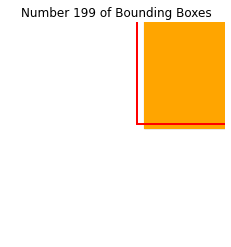

<Figure size 1080x720 with 0 Axes>

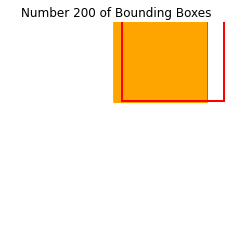

In [ ]:
# import numpy as np
# import pandas as pd

#from function import overlapScore

# import torch

#from cnn_model import cnn_model

# from matplotlib import patches
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
from fastai.basics import *
# load test data
# implement your code here
def test_model():
  #loading data for testing
    testing = torch.tensor(pd.read_csv(path_of_dataset_folder + "testData.csv", header=None).to_numpy(), dtype=torch.float)
    
    #loading data for actual value
    ground_test = torch.tensor(pd.read_csv(path_of_dataset_folder + "ground-truth-test.csv", header=None).to_numpy(), dtype=torch.float)

    # load model.pth and test model

    model = cnn_model()
    model.eval()
    model.load_state_dict(torch.load('model.pth', map_location=torch.device('cpu')))

    # reshape your text data and feed into your model
    # implement your code here
    feeds, labels = testing.view(200, 1, 100, 100), ground_test.view(200, 4)
    outputs = model(feeds)

    # use overlapscore function to calculate the average score
    # implement your code here

    #getting this from overlapscores
    avgScore, scores = overlapScore(ground_test.detach().numpy(), outputs.detach().numpy())
    #return scores, feeds, labels, outputs
    return feeds, outputs, labels, scores


if __name__ == '__main__':
    feeds, outputs, actuals, scores = test_model()
    #scores, feeds, actuals, outputs = test_model()
    # save your output in a csv file in Result directory and draw an example with bounding box
    # implement your code here
    pd.DataFrame(np.array(scores)).to_csv("results.csv", header=False)
    with torch.no_grad():
      for i in range(outputs.shape[0]):
        plt.figure(figsize=(15, 10))
        fig, ax = plt.subplots()
        # Display the image, origin at bottom left
        ax.imshow(feeds[i][0], origin='lower', cmap='binary')
        # Create Bounding boxes
        actual = actuals[i]
        rect_truth = patches.Rectangle((actual[0], actual[1]), actual[2], actual[3], linewidth=2, edgecolor='orange',
                                       facecolor='orange')
        #add the truth rectangle to the picture and show the difference from hollow green
        ax.add_patch(rect_truth)

        output_1 = outputs[i]
        rect_pred = patches.Rectangle((output_1[0], output_1[1]), output_1[2], output_1[3], linewidth=2, edgecolor='red',
                                      facecolor='none')
        #add the predicted to the axes as green and hollow
        ax.add_patch(rect_pred)
        plt.title("Number " + str(i+1) +' of Bounding Boxes')
        plt.axis("off")
        plt.show()
        fig.savefig("Number " +str(i+1) + "result.png")

Note: Please submit your code and the pdf report or your ipynb summarizing your results in one zip file **FirstnameLastname.zip**. You do not need to submit your model.pth file.